In [57]:
import pandas as pd
import numpy as np

import os
for dirname, _, filenames in os.walk("./nasa-cmaps/versions"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./nasa-cmaps/versions\1\CMaps\Damage Propagation Modeling.pdf
./nasa-cmaps/versions\1\CMaps\readme.txt
./nasa-cmaps/versions\1\CMaps\RUL_FD001.txt
./nasa-cmaps/versions\1\CMaps\RUL_FD002.txt
./nasa-cmaps/versions\1\CMaps\RUL_FD003.txt
./nasa-cmaps/versions\1\CMaps\RUL_FD004.txt
./nasa-cmaps/versions\1\CMaps\test_FD001.txt
./nasa-cmaps/versions\1\CMaps\test_FD002.txt
./nasa-cmaps/versions\1\CMaps\test_FD003.txt
./nasa-cmaps/versions\1\CMaps\test_FD004.txt
./nasa-cmaps/versions\1\CMaps\train_FD001.txt
./nasa-cmaps/versions\1\CMaps\train_FD002.txt
./nasa-cmaps/versions\1\CMaps\train_FD003.txt
./nasa-cmaps/versions\1\CMaps\train_FD004.txt
./nasa-cmaps/versions\1\CMaps\x.txt


In [58]:
# 모델 임포트
import numpy as np
import pandas as pd

import torch
import random
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [59]:
import pandas as pd
import numpy as np

index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [60]:
dftrain = pd.read_csv('./nasa-cmaps/versions/1/CMaps/train_FD004.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('./nasa-cmaps/versions/1/CMaps/test_FD004.txt',sep='\s+',header=None,index_col=False,names=col_names)
y_valid = pd.read_csv('./nasa-cmaps/versions/1/CMaps/RUL_FD004.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
dfvalid.shape

(41214, 26)

In [61]:
train = dftrain.copy()
valid = dfvalid.copy()

# 데이터 설명

현재 주어진 데이터
:
- train_FD001 ~ 004.txt : 기계가 고장날 때 까지의 데이터
- RUL_FD001 ~ 004.txt : 기계가 고장나기 전에 멈춘 데이터
- test_FD001 ~ 004.txt : test셋의 기계의 실제 잔여수명(RUL)

총 26개의 컬럼

    - 1 : unit_number (엔진 ID)
    - 2 : time_in_cycles (운전 사이클 시간축)
    - 3~5 : operational_setting 1~3 (운전 설정 값)
    - 6~26 : sensor_measurement_1~21 (센서 값 - 온도, 압력, 회전수 등)

In [62]:
train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,380.16,2388.73,8185.69,8.4541,0.03,372,2319,100.00,29.11,17.5234
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,535.02,2388.46,8185.47,8.2221,0.03,396,2388,100.00,39.38,23.7151
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,535.41,2388.48,8193.94,8.2525,0.03,395,2388,100.00,39.78,23.8270
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,187.92,2388.83,8125.64,9.0515,0.02,337,2223,100.00,15.26,9.0774


In [63]:
dftrain = pd.read_csv('./nasa-cmaps/versions/1/CMaps/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('./nasa-cmaps/versions/1/CMaps/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
y_valid = pd.read_csv('./nasa-cmaps/versions/1/CMaps/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
dfvalid.shape

(13096, 26)

In [64]:
train = dftrain.copy()
valid = dfvalid.copy()
train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_number  20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   s_1          20631 non-null  float64
 6   s_2          20631 non-null  float64
 7   s_3          20631 non-null  float64
 8   s_4          20631 non-null  float64
 9   s_5          20631 non-null  float64
 10  s_6          20631 non-null  float64
 11  s_7          20631 non-null  float64
 12  s_8          20631 non-null  float64
 13  s_9          20631 non-null  float64
 14  s_10         20631 non-null  float64
 15  s_11         20631 non-null  float64
 16  s_12         20631 non-null  float64
 17  s_13         20631 non-null  float64
 18  s_14         20631 non-null  float64
 19  s_15

In [66]:
train.describe()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [67]:
train.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [68]:
train.loc[:, ['unit_number', 'time_cycles']].describe()

,unit_number,time_cycles
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


train셋은 고장까지의 데이터셋이므로 RUL을 구할 수 있음

In [69]:
train = dftrain.copy()

In [70]:
train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [71]:
def get_RUL(df):
    df['RUL'] = max(df['time_cycles']) - df['time_cycles']
    return df

train = train.groupby('unit_number').apply(get_RUL).reset_index(drop=True)
train.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [72]:
# 한글 출력 문제 해결
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

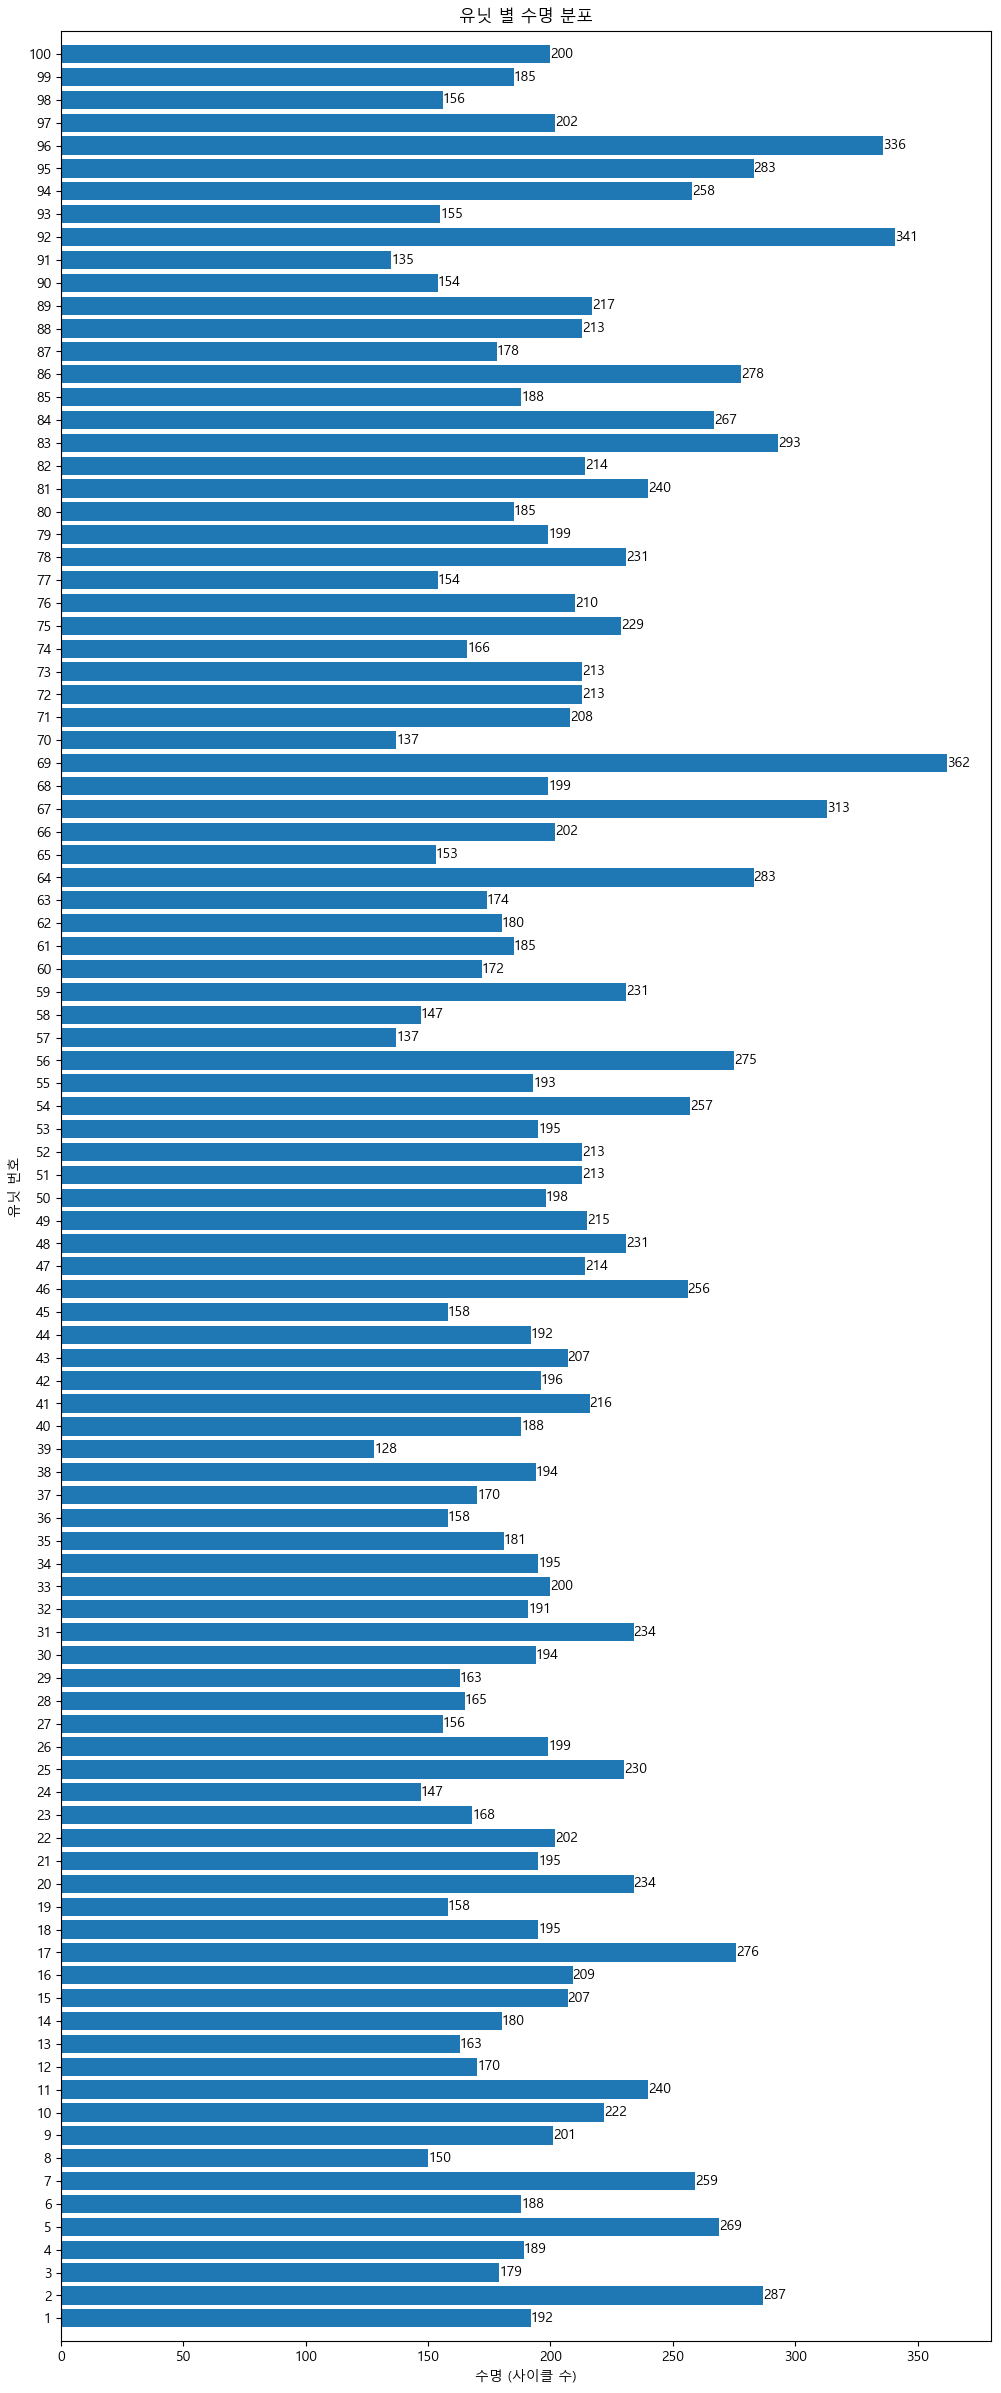

In [73]:
# 유닛 별 수명 분포
unit_counts = train['unit_number'].value_counts().sort_index()
plt.figure(figsize=(12,30))
plt.barh(unit_counts.index, unit_counts.values)
# 각각 유닛 번호 과 수명(사이클 수)을 라벨로 지정
for i in range(len(unit_counts)):
    plt.text(unit_counts.values[i], unit_counts.index[i], str(unit_counts.values[i]), va='center')
# 유닛 이름 모두 출력
plt.yticks(rotation=0)
plt.ylabel('유닛 번호')
plt.ylim(0, unit_counts.index.max()+1)
plt.yticks(unit_counts.index)
plt.xlabel('수명 (사이클 수)')
plt.title('유닛 별 수명 분포')
plt.show()

In [74]:
train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


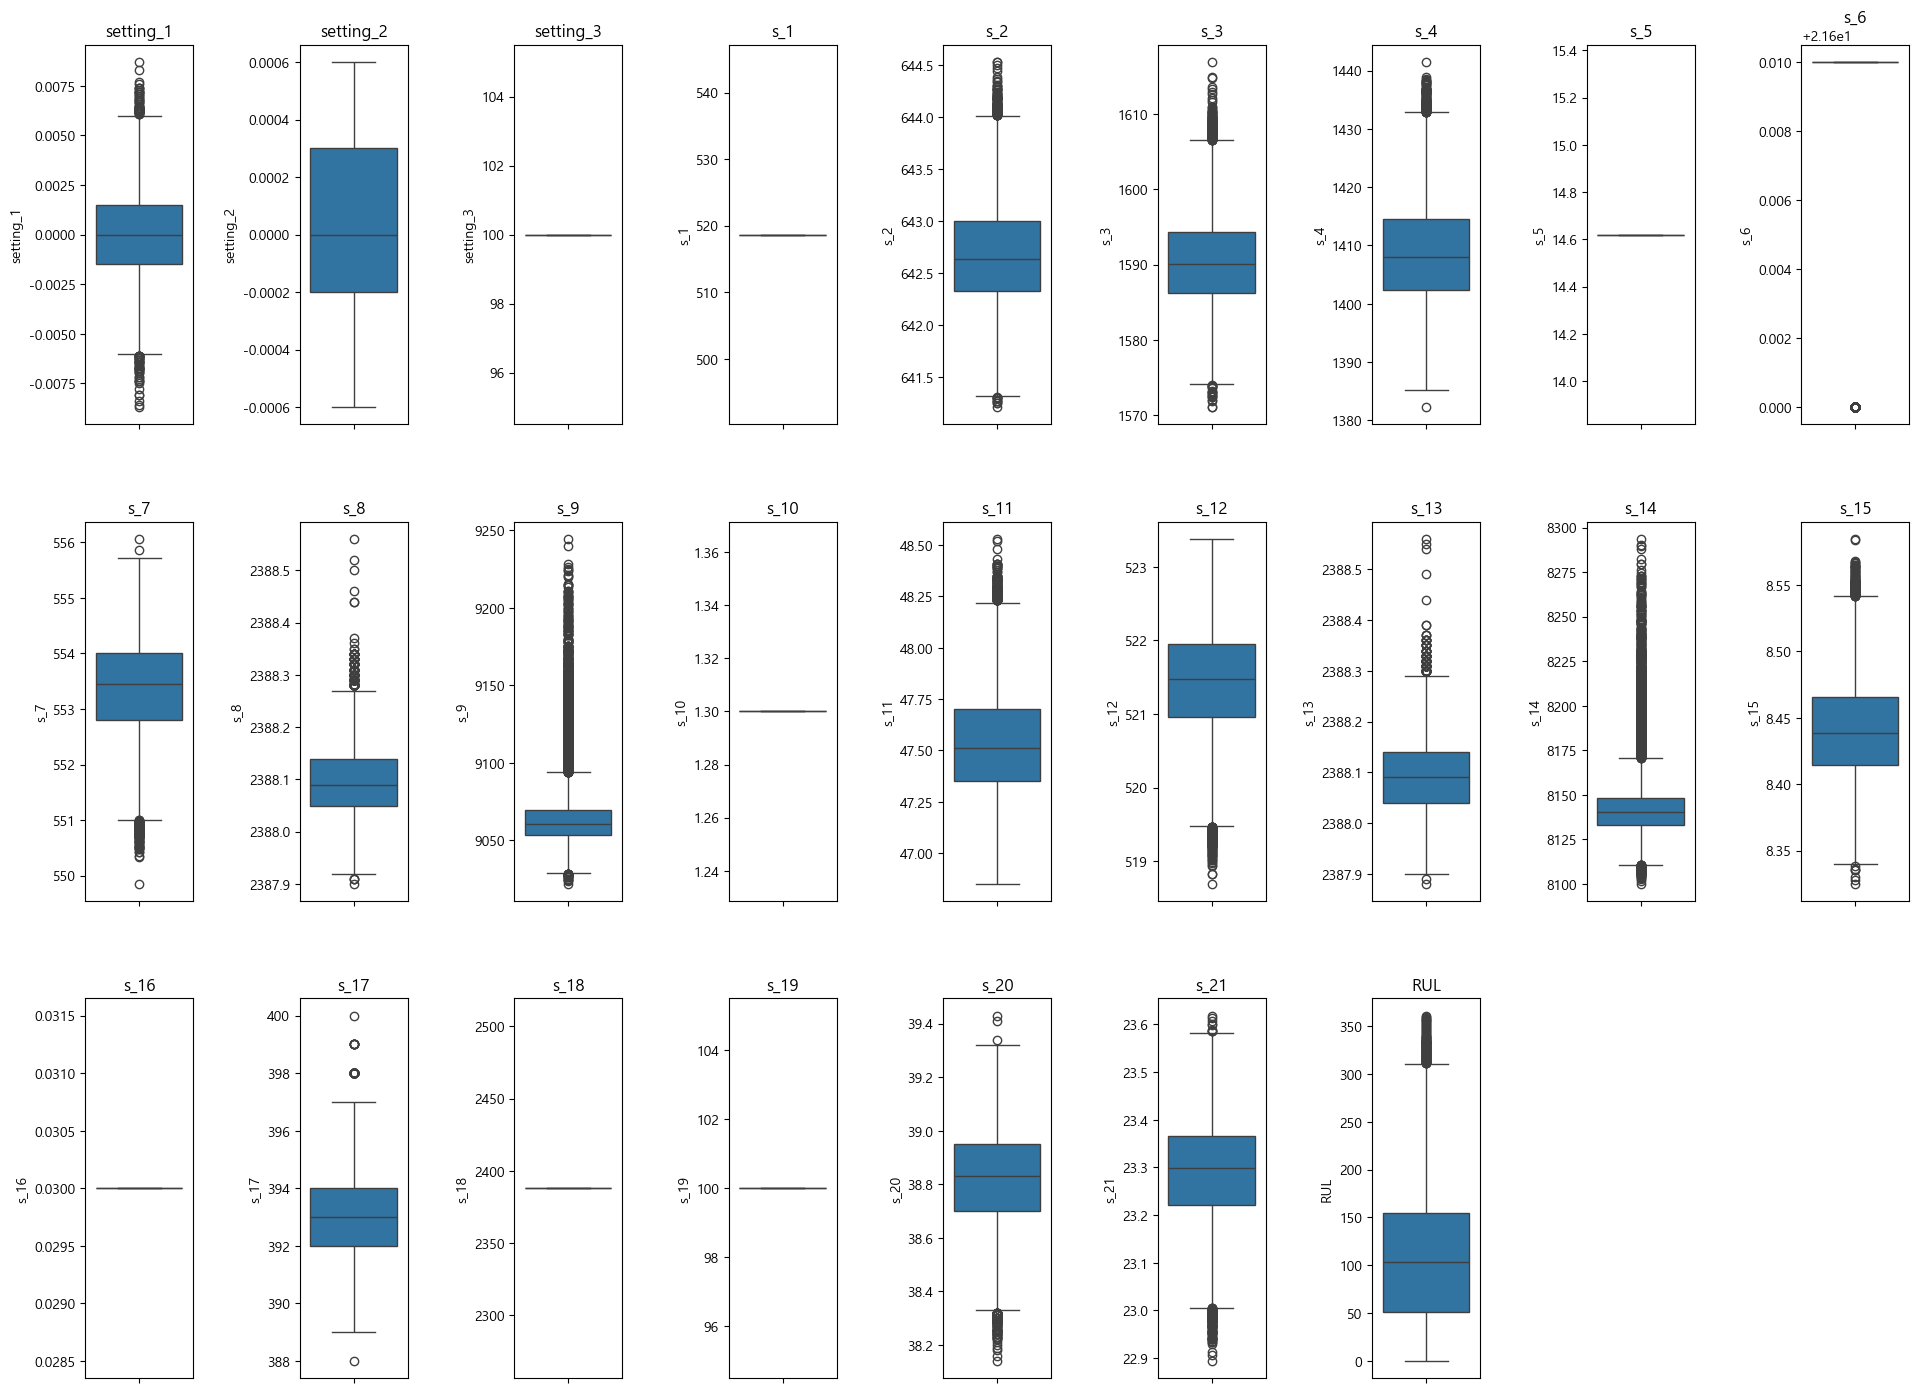

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# 센서 데이터만 추출
sensor_columns = [col for col in train.iloc[:, 2:].columns]

# 서브플롯 생성
fig, axes = plt.subplots(3, 9, figsize=(20, 15))  # 3행 9열 서브플롯
fig.tight_layout(pad=5.0)  # 서브플롯 간 간격 조정

# 각 센서 데이터에 대해 박스플롯 생성
for i, sensor in enumerate(sensor_columns):
    row, col = divmod(i, 9)  # 행과 열 계산
    sns.boxplot(data=train, y=sensor, ax=axes[row, col])
    axes[row, col].set_title(sensor)

# 남은 빈 서브플롯 숨기기
for j in range(len(sensor_columns), 27):  # 총 3x9=27개의 서브플롯
    row, col = divmod(j, 9)
    axes[row, col].axis('off')

plt.show()

<BarContainer object of 24 artists>

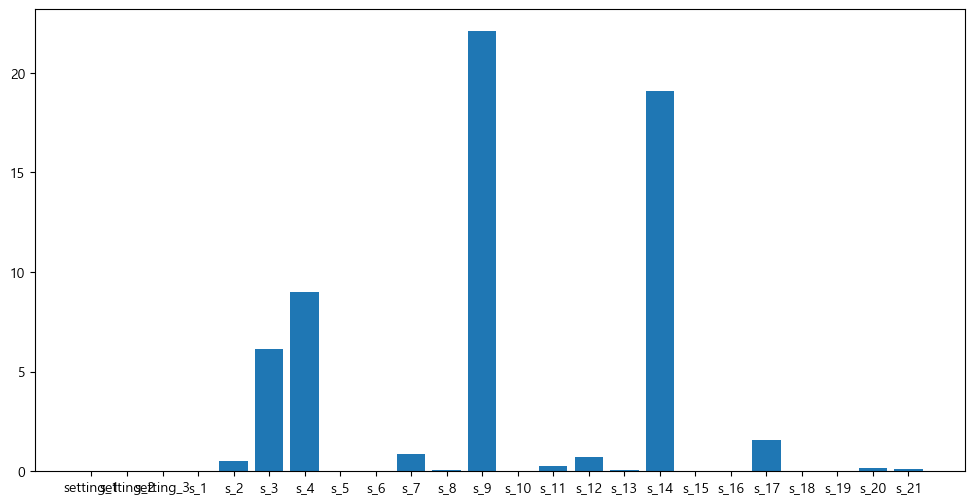

In [75]:
# 모든 센서의 편차 플롯 출력
std = train.iloc[:, 2:-1].std()
plt.figure(figsize=(12,6))
plt.bar(std.index, std.values)

In [76]:
train.value_counts('unit_number').sort_values()

unit_number
39    128
91    135
57    137
70    137
58    147
     ... 
83    293
67    313
96    336
92    341
69    362
Name: count, Length: 100, dtype: int64

In [77]:
features = ['s_2', 's_3', 's_4', 's_7', 's_9', 's_11', 's_12', 's_13', 's_14', 's_17', 's_20', 's_21']

In [78]:
target = train['RUL']
train = train[ ['unit_number', 'time_cycles'] + features]

---

LSTM 적용해보기..

In [79]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

일단은 df에 unit, time을 포함하고 골라낸 피쳐만 사용해보기

In [81]:
train = dftrain.copy()
features = ['s_2', 's_3', 's_4', 's_7', 's_9', 's_11', 's_12', 's_13', 's_14', 's_17', 's_20', 's_21']
df = train[['unit_number', 'time_cycles'] + features]

In [83]:
def get_RUL(df):
    df['RUL'] = max(df['time_cycles']) - df['time_cycles']
    return df

train = train.groupby('unit_number').apply(get_RUL).reset_index(drop=True)
train.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [87]:
# train/val 유닛 분할 (unit 단위로 누설 방지)
df = train.copy()
units = df['unit_number'].unique()
rng = np.random.default_rng(42) # 재현성을 위한 시드 설정
rng.shuffle(units) # 유닛 섞기
train_units = set(units[:80])
val_units = set(units[80:])
# set()을 사용하여 중복 제거

train_df = df[df.unit_number.isin(train_units)].copy()
val_df = df[df.unit_number.isin(val_units)].copy()

In [ ]:
# 스케일링(훈련셋으로 피팅) - 일단 여기는 패스

In [91]:
# 슬라이딩 윈도우 데이터셋
class WindowDataset(Dataset):
    def __init__(self, data: pd.DataFrame, features, seq_len=30, stride=1):
        self.features = features
        self.seq_len = seq_len
        self.X, self.y = [], []
        # unit별로 윈도우 생성
        for u, g in data.groupby('unit_number'):
            g = g.sort_values('time_cycles') # 시간 순 정렬
            arr = g[features].values.astype(np.float32) # 피쳐 배열
            rul = g["RUL"].values.astype(np.float32) # RUL 배열
            T = len(g) # 유닛의 전체 시간 길이

            # 고장까지 전 구간에서 window 생성
            for end in range(self.seq_len, T, stride):
                start = end - (self.seq_len - 1) # 윈도우 시작 인덱스
                self.X.append(arr[start:end+1]) # 윈도우 데이터 추가
                self.y.append(rul[end]) # 해당 시점 RUL 추가
        self.X = np.stack(self.X) # (N, seq_len, n_features)
        self.y = np.array(self.y) # (N,)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx])
        y = torch.tensor(self.y[idx]).float()
        return x, y

In [92]:
seq_len = 50 # 보통 30 ~ 100이며, 데이터/성능을 보고 조정
train_dataset = WindowDataset(train_df, features, seq_len=seq_len, stride=1)
val_dataset = WindowDataset(val_df, features, seq_len=seq_len, stride=1)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [93]:
# LSTM Regressor 모델
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False, # 양방향 LSTM은 시계열 예측에 적합하지 않음
            dropout=dropout if num_layers > 1 else 0.0
        )
        out_dim = hidden_size * (2 if self.lstm.bidirectional else 1) # 양방향일 경우 출력 차원 조정
        self.head = nn.Sequential(
            nn.Linear(out_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        ) # 최종 출력은 1차원 (RUL 예측), 하이퍼 파라미터 조정 필요

    def forward(self, x):
        out, _ = self.lstm(x) # LSTM 통과
        out = out[:, -1, :] # 마지막 타임스텝 출력 선택
        out = self.head(out) # Fully Connected Layer 통과
        return out.squeeze() # (B,) 형태로 반환

주제가 얼마나 괜찮은지 (아이디어, 쓸모, 확장성) - 예상 결과물, 데이터 어디서?, 기획때 말한 결과대로 나왔는지, 적절한 알고리즘 사용했는지?

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_size=len(features), hidden_size=128, num_layers=2, dropout=0.2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # weight_decay는 L2 정규화, 일단 사용 X
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
# scheduler는 검증 손실이 개선되지 않을 때 학습률 감소, patience는 몇 에폭 동안 개선되지 않으면 감소할지 설정

c:\Users\ASUS\anaconda3\envs\ds_study\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [101]:
# 학습 루프
def run_epoch(loader, train=True):
    model.train(train)
    total_loss, n = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        with torch.set_grad_enabled(train):
            pred = model(xb)
            loss = criterion(pred, yb)
        if train:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item() * xb.size(0)
        n += xb.size(0)
    return np.sqrt(total_loss / n) # rmse

In [102]:
best_val = np.inf
for epoch in range(30):
    train_rmse = run_epoch(train_loader, train=True)
    val_rmse = run_epoch(val_loader, train=False)
    scheduler.step(val_rmse)
    print(f"{epoch+1:02d}: Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}")
    if val_rmse < best_val:
        best_val = val_rmse
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

01: Train RMSE: 57.5344, Val RMSE: 55.8095
Best model saved.
02: Train RMSE: 57.5078, Val RMSE: 55.8125
03: Train RMSE: 57.4908, Val RMSE: 55.8039
Best model saved.
04: Train RMSE: 57.4989, Val RMSE: 55.8181
05: Train RMSE: 57.5109, Val RMSE: 55.8211
06: Train RMSE: 57.5183, Val RMSE: 55.8039
07: Train RMSE: 57.5026, Val RMSE: 55.8003
Best model saved.
08: Train RMSE: 57.5008, Val RMSE: 55.8926
09: Train RMSE: 57.5201, Val RMSE: 55.8154
10: Train RMSE: 57.5106, Val RMSE: 55.8010
11: Train RMSE: 57.4942, Val RMSE: 55.8069
12: Train RMSE: 57.4829, Val RMSE: 55.8033
13: Train RMSE: 57.4856, Val RMSE: 55.8174
14: Train RMSE: 57.4828, Val RMSE: 55.8024
15: Train RMSE: 57.4973, Val RMSE: 55.8057
16: Train RMSE: 57.4894, Val RMSE: 55.8310
17: Train RMSE: 57.4892, Val RMSE: 55.8011
18: Train RMSE: 57.4753, Val RMSE: 55.9193
19: Train RMSE: 57.4918, Val RMSE: 55.8068
20: Train RMSE: 57.4785, Val RMSE: 55.8062
21: Train RMSE: 57.4795, Val RMSE: 55.8346
22: Train RMSE: 57.4691, Val RMSE: 55.8010


---

예측 진행해보기

In [103]:
features

['s_2',
 's_3',
 's_4',
 's_7',
 's_9',
 's_11',
 's_12',
 's_13',
 's_14',
 's_17',
 's_20',
 's_21']

In [104]:
test_path = './nasa-cmaps/versions/1/CMaps/test_FD004.txt'
rul_path = './nasa-cmaps/versions/1/CMaps/RUL_FD004.txt'

# 훈련때와 같은 컬럼 스키마를 반드시 유지
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

df_test = pd.read_csv(test_path, sep='\s+', header=None, index_col=False, names=col_names)
df_rul = pd.read_csv(rul_path, sep='\s+', header=None, index_col=False, names=['RUL'])

df_test = df_test[['unit_number', 'time_cycles'] + features]

In [110]:
import torch
import numpy as np
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 생성 (훈련 때와 동일한 하이퍼파라미터 사용)
model = LSTM(input_size=len(features), hidden_size=128, num_layers=2, dropout=0.2).to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

seq_len = 50  # 훈련 때 사용한 seq_len와 동일해야 함

preds = []
units = []
for u, g in df_test.groupby('unit_number'):
    g = g.sort_values('time_cycles')
    arr = g[features].values.astype(np.float32)
    T = len(arr)
    if T >= seq_len:
        window = arr[-seq_len:]
    else:
        # 짧으면 앞쪽 값(또는 0)으로 패딩 — 학습 때 처리 방식에 맞게 조정
        pad = np.repeat(arr[0:1], seq_len - T, axis=0)
        window = np.vstack([pad, arr])
    x = torch.from_numpy(window).unsqueeze(0).to(device)  # (1, seq_len, n_features)
    with torch.no_grad():
        pred = model(x).item()
    preds.append(pred)
    units.append(u)

results = pd.DataFrame({'unit_number': units, 'pred_RUL': preds}).sort_values('unit_number').reset_index(drop=True)

# 실제 RUL 파일은 unit 순서(1..N)로 제공됨 — df_rul 읽은 변수 사용
# df_rul은 한 열 'RUL'로 되어 있다고 가정
df_rul_idx = df_rul.reset_index(drop=True).copy()
df_rul_idx['unit_number'] = np.arange(1, len(df_rul_idx) + 1)

merged = pd.merge(df_rul_idx, results, on='unit_number', how='left')
rmse = np.sqrt(((merged['RUL'] - merged['pred_RUL']) ** 2).mean())

print(merged.head())
print(f'Test RMSE (per-unit final window): {rmse:.4f}')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6276\860387579.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_location

   RUL  unit_number   pred_RUL
0   22            1  84.063560
1   39            2  84.062546
2  107            3  84.063896
3   75            4  84.065941
4  149            5  84.063553
Test RMSE (per-unit final window): 54.5806
